In [ ]:
!pip install mlflow

In [ ]:
MLFLOW_TRACKING_URI='http://ec2-54-87-129-244.compute-1.amazonaws.com:5000/'
import mlflow

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
with mlflow.start_run():
  mlflow.log_param('param1',15)
  mlflow.log_metric('metric1',0.89)

🏃 View run enthused-slug-765 at: http://ec2-54-87-129-244.compute-1.amazonaws.com:5000/#/experiments/0/runs/bae5d51e391540199a29df6ee2b80ee1
🧪 View experiment at: http://ec2-54-87-129-244.compute-1.amazonaws.com:5000/#/experiments/0


In [ ]:
# Creating Baseline Model
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[~(df['clean_comment'].str.strip() == '')]
df['clean_comment'] = df['clean_comment'].str.lower()
df['clean_comment'] = df['clean_comment'].str.strip()
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)
comments_with_newline = df[df['clean_comment'].str.contains('\n')]
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))


/tmp/ipython-input-6-2428455046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_comment'] = df['clean_comment'].str.lower()
/tmp/ipython-input-6-2428455046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_comment'] = df['clean_comment'].str.strip()


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt') # punkt is required for word_tokenize

stop_words = set(stopwords.words('english'))

# Create a new Column 'num_stop_words' by counting the number of stopwords in each comment
df['num_stop_words'] = df['clean_comment'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
df['num_chars'] = df['clean_comment'].apply(lambda x: len(x))
from collections import Counter
# Freq of special characters
all_text = ' '.join(df['clean_comment'])
special_char_freq = Counter(all_text)

char_freq_df = pd.DataFrame(special_char_freq.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)
import string
import re
df['num_punctuation_chars'] = df['clean_comment'].apply(lambda x: len([char for char in x if char in string.punctuation]))
df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^\w\s!?.,]', '', str(x)))
all_text = ' '.join(df['clean_comment'])

# Count Freq of each character
special_char_freq = Counter(all_text)

# Convert the character frequency into a DF for better display
char_freq_df = pd.DataFrame(special_char_freq.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.corpus import stopwords

# Keeping essential stopwords that contributes to sentiment analysis
non_essential_stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Remove non-essential stop words
df['clean_comment'] = df['clean_comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in non_essential_stop_words]))
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Define Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'clean_comment' (with no stop words)
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# 1. Vectorize the commments using Bag Of Words (CountVectorizer)
# Bag Of words model with limit of 1000 features
np.vectorizer = CountVectorizer(max_features=10000)

X = np.vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category'] # Assume 'Sentiment' is the target variable (0 or 1 for binary classification)


In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X.shape

(36793, 10000)

In [ ]:
y.shape

(36793,)

In [ ]:
# 2. Set up MLflow tracking server
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# Create an Experiment
mlflow.set_experiment("RF Baseline")

<Experiment: artifact_location='s3://sumanthdatahub/mlflow-artifacts/857327774924220070', creation_time=1753382004120, experiment_id='857327774924220070', last_update_time=1753382004120, lifecycle_stage='active', name='RF Baseline', tags={}>

In [ ]:
!pip install boto3

In [ ]:
!pip install awscli

## Split and Log Experiment

In [ ]:
from google.colab import userdata
import os
import boto3 # Assuming boto3 is installed

# Retrieve AWS credentials from Colab Secrets
aws_access_key = userdata.get('AWS_ACCESS_KEY_ID')
aws_secret_key = userdata.get('AWS_SECRET_ACCESS_KEY')

# Set as environment variables (for boto3 and AWS CLI)
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_key

2025/07/24 21:46:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/24 21:46:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForst_Baseline_TrainTestSplit at: http://ec2-54-87-129-244.compute-1.amazonaws.com:5000/#/experiments/857327774924220070/runs/f427a329173b4979a544cf5b5e954869
🧪 View experiment at: http://ec2-54-87-129-244.compute-1.amazonaws.com:5000/#/experiments/857327774924220070


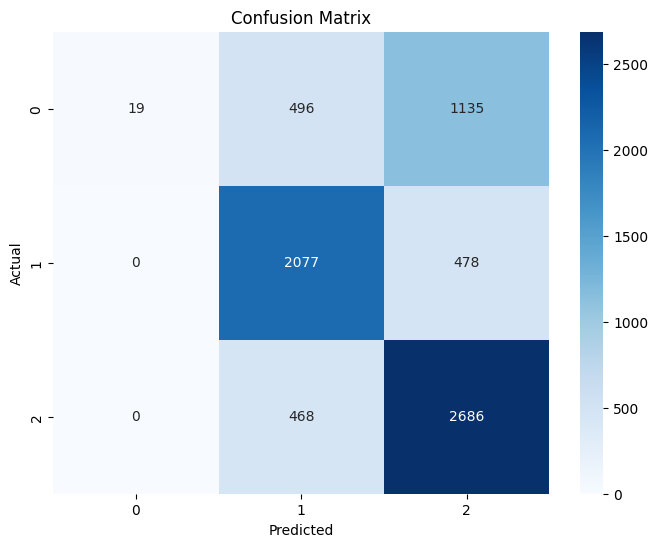

In [ ]:
# 1. SPlit Data into training test sets (80% train, 20% test )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Define and Train Random Foresr Baseline model using above train-test split
with mlflow.start_run():
  mlflow.set_tag("mlflow.runName", "RandomForst_Baseline_TrainTestSplit")
  mlflow.set_tag("experiment_type", "baseline")
  mlflow.set_tag("model_type", "RandomForestClassifier")

  # add description
  mlflow.set_tag("description", "Baseline RF model for sentiment analysis using Bag of Words (BOW)")




  n_estimators = 200
  max_depth = 15
  # Log parameters
  log_params = {
      "vector_type": "CountVectorizer",
      "vectorizer_max_features": np.vectorizer.max_features,
      "n_estimators": n_estimators,
      "max_depth": max_depth,
      "random_state": 42,
      "stratify": True
                }
  mlflow.log_params(log_params)

  # Train the model
  rf_baseline = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
  rf_baseline.fit(X_train, y_train)

  # Make Predictions on test set
  y_pred = rf_baseline.predict(X_test)

  # Log Metrics
  accuracy = accuracy_score(y_test, y_pred)
  mlflow.log_metric("accuracy", accuracy)

  classification_metrics = classification_report(y_test, y_pred, output_dict=True)

  for label, metrics in classification_metrics.items():
    if isinstance(metrics, dict):
      for metric, value in metrics.items():
        mlflow.log_metric(f"{label}_{metric}", value)

  # Confuction Matrix plot
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')

  # Save and Log Confusion Matrix Plot
  plt.savefig('confusion_matrix.png')
  mlflow.log_artifact('/content/confusion_matrix.png')

  # Log Random Forest Model
  mlflow.sklearn.log_model(rf_baseline, "random_forest_model")

  # Log the daatset itself if smalle enough
  df.to_csv('dataset.csv', index=False)
  mlflow.log_artifact('/content/dataset.csv')

In [ ]:
df.to_csv('reddit_preprocessing.csv', index=False)

In [ ]:
pd.read_csv('reddit_preprocessing.csv')

,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0
...,...,...,...,...,...,...
36788,jesus,0,1,0,5,0
36789,kya bhai pure saal chutiya banaya modi aur jab...,1,19,0,99,0
36790,downvote karna tha par upvote hogaya,0,6,0,36,0
36791,haha nice,1,2,0,9,0
